# ISIS Tweets Classification

### Libreries

In [ ]:
# !pip install nltk
# !pip install textblob
# !pip uninstall nltk
# !pip install nltk
# !pip install textblob
# !pip install langdetect
# !pip install wordcloud
# !pip install chardet
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# !pip install Corpora
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')
# !pip install xgboost

In [46]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from langdetect import detect_langs
from langdetect import DetectorFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

### Load Data

In [3]:
tweets = pd.read_csv("Tweets.csv")

tweets.info()                 #  tweets['ISIS Flag'].unique() yields 3 options -> [0, 1, nan]
tweets.dropna(inplace=True)   #  tweet.info() has now 139774 entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199987 entries, 0 to 199986
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ISIS Flag  139774 non-null  float64
 1   Tweet      139774 non-null  object 
dtypes: float64(1), object(1)
memory usage: 3.1+ MB


### Data Exploration - Class Balance

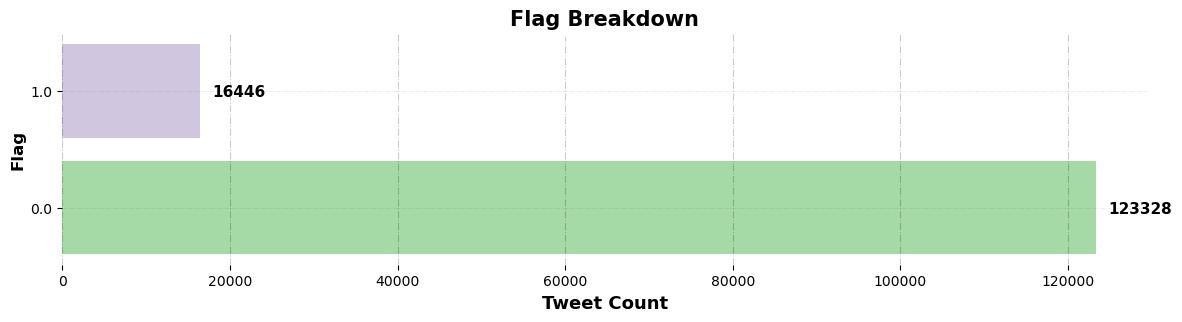

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

xlabels = list(map(str, tweets['ISIS Flag'].unique().tolist()))
ylabels = [tweets['ISIS Flag'].value_counts()[i] for i in range(2)]

fig, ax = plt.subplots(figsize=(14, 3))
ax.barh(xlabels, ylabels, color=sns.color_palette('Accent'), alpha=0.7)

# Configure the grid lines
ax.grid(True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
ax.set_title('Flag Breakdown', backgroundcolor='white', fontsize=15, weight='bold', color='black', loc='center')

plt.box(False)
ax.xaxis.grid(linewidth=0.8, color='black', linestyle='-.')

ax.set_xlabel('Tweet Count', weight='bold', color='black', fontsize=13)
ax.set_ylabel('Flag', weight='bold', fontsize=12)

for i, v in enumerate(ylabels):
    ax.text(v + 1500, i - 0.05, str(v), color='black', fontsize=11, fontweight='bold')

plt.show()

### Main Language Distribution Check

In [157]:
suspicious = tweets[tweets['ISIS Flag'] == 1.0].Tweet.index

# Suggested in the documentation for small texts
DetectorFactory.seed = 42          

def language_detector():
    Languages = []
    for itr in suspicious:
        try:
            main_language = detect_langs(tweets.Tweet[itr])[0]
            Languages.append(main_language.lang)
        except:
            pass 
    return Languages


ISIS_tweets = pd.DataFrame(language_detector(), columns=['MainLanguage'])

for col in ISIS_tweets.columns:
    ISIS_tweets[col] = ISIS_tweets[col].astype('str').str[:2]

ISIS_tweets  #<--- show df 

,MainLanguage
0,en
1,id
2,fr
3,en
4,en
...,...
15653,en
15654,en
15655,en
15656,en


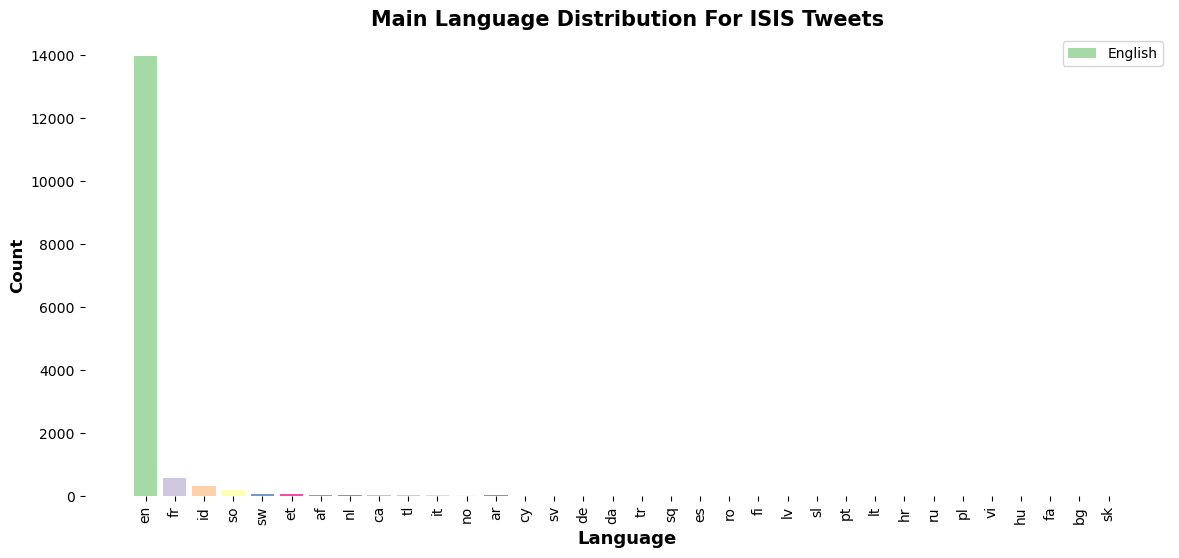

In [72]:
Language_plot = ISIS_tweets.MainLanguage.value_counts().reset_index()
Language_plot.columns = ['Language', 'Count']

xlabels = Language_plot['Language'].tolist()
ylabels = Language_plot['Count'].tolist()


fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(xlabels, ylabels, color=sns.color_palette('Accent'), alpha=0.7)
ax.set_title('Main Language Distribution For ISIS Tweets', fontsize=15, weight='bold', color='black')
ax.set_xlabel('Language', weight='bold', color='black', fontsize=13)
ax.set_ylabel('Count', weight='bold', fontsize=12)
plt.xticks(rotation=90)
plt.box(False)
plt.legend(['English', 'French', 'Indonesian'], loc='upper right')
plt.show()

###  Feature Selection

#### First Round

In [14]:
tweets['Tweet'] = tweets.Tweet.str.lower()           
tweets['Tweet'] = tweets.Tweet.apply(lambda x: re.sub(r'https\S+', '', x))                              # URL removal ('https')
tweets['Tweet'] = tweets.Tweet.apply(lambda x: re.sub(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', '', x))    # URL removal ('www')
tweets['Hashtag'] = tweets.Tweet.apply(lambda x: re.findall(r'#(\w+)', x))
tweets['Tweet'] = tweets.Tweet.replace('#', '')                                                         # Hashtag removal
tweets['Handles'] = tweets.Tweet.apply(lambda x: re.findall(r'@([a-zA-Z0-9_]{1,50})', x))                     
tweets['Tweet'] = tweets.Tweet.apply(lambda x: re.sub(r'@[A-Za-z0-9_]+', '', x))                        # Handles removal
tweets['Tweet'] = tweets.Tweet.apply(lambda x: re.sub(r"\\\w+", '', x))                                 # Removal charecters that starts with '\' 
tweets['Tweet'] = tweets.Tweet.apply(lambda x: re.sub(r'\d+','', x))                                    # Digits removal
tweets['Tweet'] = tweets.Tweet.apply(lambda x: re.sub(r'[^\w\s]','', x))                                # Punctuation  removal
tweets['Tweet'] = tweets.Tweet.apply(lambda x: re.sub(r"\b[a-zA-Z]\b", "", x))                          # Single charecter remove

tweets  #<--- show df 

,ISIS Flag,Tweet,Hashtag,Handles
0,0.0,is doing more to repair race relations than ...,[],"[kanyewest, barackobama]"
1,0.0,the best days of our life has just started ...,[],[]
2,0.0,ivotebtsbbmas,[ivotebtsbbmas],[bts_twt]
3,0.0,gonna drive you home tonite,[],[uber]
4,0.0,pm kst fake love mv new songs to love the da...,[],[]
...,...,...,...,...
139769,1.0,killing nusayri soldiers and taking control...,[islamicstate],[]
139770,1.0,martyrdom operation hits syrian opposition f...,[],[]
139771,1.0,medical sources to amaqagency the chemical w...,[amaqagency],[]
139772,1.0,peshmerga forces backed by usa indiscriminat...,[],[]


#### Second Round

In [16]:
def stop_token_lemma(tweet):    
    stop_words = set(stopwords.words('english'))
    tweet_blob = TextBlob(tweet)
    tokens = tweet_blob.tags                                            # Part of speech tagging
    a_ok = []
    for i in range(len(tokens)):
        if tokens[i][0] not in stop_words:                              # Drop stop words
            if len(tokens[i][0]) > 1:                                   # Drop one-character tokens
                try:
                    token = tokens[i][0].lemmatize(tokens[i][1])        # Apply lemmatization
                    a_ok.append(token)
                except:
                    token = tokens[i][0].lemmatize()
                    a_ok.append(token)
    return a_ok


tweets['Tokens'] = tweets.Tweet.apply(stop_token_lemma)
tweets   # <--- show df 

,ISIS Flag,Tweet,Hashtag,Handles,Tokens
0,0.0,is doing more to repair race relations than ...,[],"[kanyewest, barackobama]","[repair, race, relation, ever]"
1,0.0,the best days of our life has just started ...,[],[],"[best, day, life, start, allah, enable, u, goo..."
2,0.0,ivotebtsbbmas,[ivotebtsbbmas],[bts_twt],[ivotebtsbbmas]
3,0.0,gonna drive you home tonite,[],[uber],"[gon, na, drive, home, tonite]"
4,0.0,pm kst fake love mv new songs to love the da...,[],[],"[pm, kst, fake, love, mv, new, song, love, dan..."
...,...,...,...,...,...
139769,1.0,killing nusayri soldiers and taking control...,[islamicstate],[],"[kill, nusayri, soldier, take, control, point,..."
139770,1.0,martyrdom operation hits syrian opposition f...,[],[],"[martyrdom, operation, hit, syrian, opposition..."
139771,1.0,medical sources to amaqagency the chemical w...,[amaqagency],[],"[medical, source, amaqagency, chemical, weapon..."
139772,1.0,peshmerga forces backed by usa indiscriminat...,[],[],"[peshmerga, force, back, usa, indiscriminately..."


In [17]:
tweets['Token Length'] = tweets.Tokens.apply(lambda x: len(x))

# Drop tweets with less than 2 tokens
indexs = tweets[(tweets['Token Length'] == 0) | (tweets['Token Length'] == 1)].index

tweets.drop(indexs, inplace=True)
tweets.reset_index(drop=True, inplace=True)

tweets  #<--- show df 

,ISIS Flag,Tweet,Hashtag,Handles,Tokens,Token Length
0,0.0,is doing more to repair race relations than ...,[],"[kanyewest, barackobama]","[repair, race, relation, ever]",4
1,0.0,the best days of our life has just started ...,[],[],"[best, day, life, start, allah, enable, u, goo...",10
2,0.0,gonna drive you home tonite,[],[uber],"[gon, na, drive, home, tonite]",5
3,0.0,pm kst fake love mv new songs to love the da...,[],[],"[pm, kst, fake, love, mv, new, song, love, dan...",15
4,0.0,happy family,[],[],"[happy, family]",2
...,...,...,...,...,...,...
133540,1.0,killing nusayri soldiers and taking control...,[islamicstate],[],"[kill, nusayri, soldier, take, control, point,...",9
133541,1.0,martyrdom operation hits syrian opposition f...,[],[],"[martyrdom, operation, hit, syrian, opposition...",11
133542,1.0,medical sources to amaqagency the chemical w...,[amaqagency],[],"[medical, source, amaqagency, chemical, weapon...",10
133543,1.0,peshmerga forces backed by usa indiscriminat...,[],[],"[peshmerga, force, back, usa, indiscriminately...",11


### ISIS\Non-ISIS Tweet Distribution

In [102]:
# Process for ISIS Flag = 1
tweet_length_1 = tweets[tweets['ISIS Flag'] == 1]['Token Length'].value_counts().reset_index()
tweet_length_1.columns = ['TokensPerTweet', 'NumTweets']

# Process for ISIS Flag = 0
tweet_length_0 = tweets[tweets['ISIS Flag'] == 0]['Token Length'].value_counts().reset_index()
tweet_length_0.columns = ['TokensPerTweet', 'NumTweets']

# Merge DataFrames
tweet_length = pd.merge(tweet_length_0, tweet_length_1, on='TokensPerTweet', how='outer', suffixes=('NonISIS', 'ISIS'))

# Replace NaN values with 0
tweet_length.fillna(0, inplace=True)

tweet_length

,TokensPerTweet,NumTweetsNonISIS,NumTweetsISIS
0,2,7044.0,521
1,3,8364.0,566
2,4,8849.0,632
3,5,9456.0,667
4,6,9408.0,800
5,7,10078.0,911
6,8,10545.0,1103
7,9,11720.0,1348
8,10,12122.0,1577
9,11,11189.0,1719


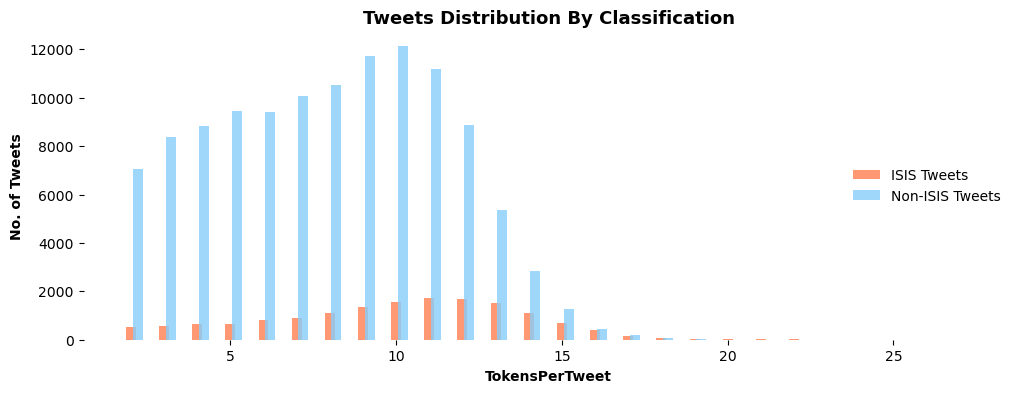

In [104]:
ISIS = tweet_length['NumTweetsISIS'].to_list()
NON_ISIS = tweet_length['NumTweetsNonISIS'].to_list()
x_ax_1 = tweet_length['TokensPerTweet'].to_list() 

plt.figure(figsize=(12,4))
x_ax_2 = [x + 0.2 for x in x_ax_1]     
plt.bar(x_ax_1, ISIS , width = 0.3, label='ISIS Tweets', color='coral', alpha=0.8)
plt.bar(x_ax_2, NON_ISIS, width =0.3 , label='Non-ISIS Tweets', color='lightskyblue', alpha=0.8)

plt.xlabel('TokensPerTweet', weight='bold')
plt.ylabel('No. of Tweets', weight='bold')
plt.title('Tweets Distribution By Classification' ,backgroundcolor='white',
             fontsize=13,weight='bold',color='black',loc ='center')

plt.box(False)
plt.legend(loc='center right', frameon=False)
plt.show()

### WordCloud

In [22]:
tweets['Clean Tweet'] = tweets.Tokens.apply(' '.join)  # Prepare corpus
tweets

,ISIS Flag,Tweet,Hashtag,Handles,Tokens,Token Length,Clean Tweet
0,0.0,is doing more to repair race relations than ...,[],"[kanyewest, barackobama]","[repair, race, relation, ever]",4,repair race relation ever
1,0.0,the best days of our life has just started ...,[],[],"[best, day, life, start, allah, enable, u, goo...",10,best day life start allah enable u good deed may
2,0.0,gonna drive you home tonite,[],[uber],"[gon, na, drive, home, tonite]",5,gon na drive home tonite
3,0.0,pm kst fake love mv new songs to love the da...,[],[],"[pm, kst, fake, love, mv, new, song, love, dan...",15,pm kst fake love mv new song love dance step k...
4,0.0,happy family,[],[],"[happy, family]",2,happy family
...,...,...,...,...,...,...,...
133540,1.0,killing nusayri soldiers and taking control...,[islamicstate],[],"[kill, nusayri, soldier, take, control, point,...",9,kill nusayri soldier take control point edge a...
133541,1.0,martyrdom operation hits syrian opposition f...,[],[],"[martyrdom, operation, hit, syrian, opposition...",11,martyrdom operation hit syrian opposition figh...
133542,1.0,medical sources to amaqagency the chemical w...,[amaqagency],[],"[medical, source, amaqagency, chemical, weapon...",10,medical source amaqagency chemical weapon use ...
133543,1.0,peshmerga forces backed by usa indiscriminat...,[],[],"[peshmerga, force, back, usa, indiscriminately...",11,peshmerga force back usa indiscriminately shel...


In [23]:
def corpus(df, flag):
    corpus = []
    for itr in range(df.shape[0]):
        if df['ISIS Flag'][itr] == flag :
            corpus.append(df['Clean Tweet'][itr])
    return corpus

NON_ISIS_corpus = corpus(tweets, 0)
ISIS_corpus = corpus(tweets, 1) 

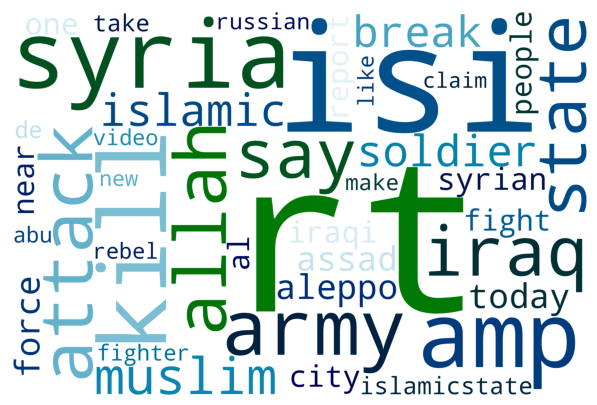

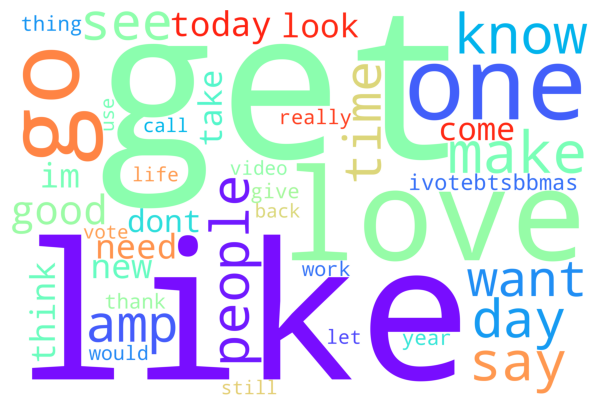

In [38]:
def vocabulary(corpus):
    tfidf = TfidfVectorizer(max_features = 50, max_df = 0.6)
    vector = tfidf.fit_transform(corpus)
    vocab = pd.DataFrame(vector.toarray(), columns=tfidf.get_feature_names_out())
    return vocab


corpuses = [ISIS_corpus, NON_ISIS_corpus]
colours = ['ocean', 'rainbow']

for itr in range(len(corpuses)):
    Cloud = WordCloud(collocations=False, width = 3000, height = 2000, random_state=420,
                      background_color='white',colormap=colours[itr],
                      max_words=40).generate_from_frequencies(vocabulary(corpuses[itr]).T.sum(axis=1))
    plt.figure(figsize=(8, 5))
    plt.axis("off")
    plt.imshow(Cloud)       # Display image

### Modeling - Random Forest Regressor

In [113]:
from imblearn.over_sampling import SMOTE

In [119]:
tfidf_vectorizer = TfidfVectorizer(max_features=500)  
X_tfidf = tfidf_vectorizer.fit_transform(tweets['Clean Tweet'])

X,y = tweets['Clean Tweet'], tweets['ISIS Flag']

X_train ,X_test ,y_train, y_test = train_test_split(X_tfidf ,y ,test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [126]:
# Define parameter grid for fine-tuning RandomForestRegressor
rfr_param_grid = {
    'n_estimators': [75],
    'max_depth': [8],
    'min_samples_split': [5],
    'min_samples_leaf': [1, 4]
}

# Fine-tuning using GridSearchCV
rfr_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rfr_param_grid, cv=5, scoring='neg_mean_squared_error') 
rfr_grid_search.fit(X_train_resampled, y_train_resampled)

# Best RandomForestRegressor model
best_rfr = rfr_grid_search.best_estimator_
best_rfr.fit(X_train_resampled, y_train_resampled)
rfr_prediction = best_rfr.predict(X_test)
rfr_rmse = np.sqrt(mean_squared_error(y_test, rfr_prediction))

print(f'Best RandomForest RMSE: {rfr_rmse:.4f}')

Best RandomForest RMSE: 0.3182


In [128]:
# Apply GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=8, random_state=42)
gbr.fit(X_train_resampled, y_train_resampled)
gbr_prediction = gbr.predict(X_test)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_prediction))

print(f'GradientBoosting RMSE: {gbr_rmse:.4f}')

GradientBoosting RMSE: 0.2661


In [129]:
# XGBoostRegressor
xgb = XGBRegressor(n_estimators=200, max_depth=8, random_state=42, objective='reg:squarederror')
xgb.fit(X_train_resampled, y_train_resampled)
xgb_prediction = xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_prediction))

print(f'XGBoost RMSE: {xgb_rmse:.4f}')

XGBoost RMSE: 0.2497


In [154]:
def optimal_cutoff(y_true, y_pred):
    thresholds = np.arange(0.0, 1.1, 0.1)
    best_threshold = 0
    best_f1 = 0

    for threshold in thresholds:
        y_pred_binary = (y_pred >= threshold).astype(int)
        report = classification_report(y_true, y_pred_binary, output_dict=True, zero_division=0)
        
        # Check if '1' key is in the classification report
        if '1' in report:
            f1 = report['1']['f1-score']
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                
    return best_threshold

def adjust_threshold(predictions, threshold=0.5):
    return (predictions >= threshold).astype(int)

# Define models and their predictions
models = {'RandomForestRegressor': rfr_prediction,
          'GradientBoostingRegressor': gbr_prediction,
          'XGBRegressor': xgb_prediction
         }

for model_name, y_pred in models.items():

    # Evaluate different thresholds to reduce false positive rate
    thresholds = np.arange(0.0, 1.1, 0.1)
    best_threshold = 0
    best_precision = 0

    for threshold in thresholds:
        y_pred_adjusted = adjust_threshold(y_pred, threshold)
        precision = precision_score(y_test, y_pred_adjusted, zero_division=0)
        
        if precision > best_precision:
            best_precision = precision
            best_threshold = threshold

    #print(f'\nBest Threshold: {best_threshold} with Precision: {best_precision:.4f}')
    
    # Apply the best threshold to get final predictions
    y_pred_final = adjust_threshold(y_pred, best_threshold)

    # Generate confusion matrix and classification report with the best threshold
    cm_final = confusion_matrix(y_test, y_pred_final)
    class_report_final = classification_report(y_test, y_pred_final, zero_division=0)

    print(f'\nModel: {model_name}\n')
    print(f'Best Threshold: {best_threshold} with Precision: {best_precision:.4f}')
    print(f'Confusion Matrix with Best Threshold:\n{cm_final}')
    print(f'Classification Report with Best Threshold:\n{class_report_final}')
    print('                ----------                ')



Model: RandomForestRegressor

Best Threshold: 0.9 with Precision: 0.8945
Confusion Matrix with Best Threshold:
[[23354   203]
 [ 1430  1722]]
Classification Report with Best Threshold:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97     23557
         1.0       0.89      0.55      0.68      3152

    accuracy                           0.94     26709
   macro avg       0.92      0.77      0.82     26709
weighted avg       0.94      0.94      0.93     26709

                ----------                

Model: GradientBoostingRegressor

Best Threshold: 1.0 with Precision: 0.9985
Confusion Matrix with Best Threshold:
[[23556     1]
 [ 2498   654]]
Classification Report with Best Threshold:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95     23557
         1.0       1.00      0.21      0.34      3152

    accuracy                           0.91     26709
   macro avg       0.95      0.60   